# BLIP-2 Experiments

This notebook contains the setup, input, and results of the experiments done on the BLIP-2 open-source LLM, taking the banana images from the Drive as input.

Firstly, we need to set up BLIP-2's API and interface. The instructions are linked here: https://huggingface.co/blog/blip-2

In [1]:
# We will import BLIP-2 through the Hugging Face Transformers Git repo
!pip3 install git+https://github.com/huggingface/transformers.git
!pip3 install --upgrade torch
!pip3 install --upgrade transformers
!pip3 install google-cloud-secret-manager
!pip3 install --upgrade pytorch-transformers
!pip3 install --upgrade accelerate

  Cloning https://github.com/huggingface/transformers.git to /var/tmp/pip-req-build-2vwwnyn1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /var/tmp/pip-req-build-2vwwnyn1
  Resolved https://github.com/huggingface/transformers.git to commit 5bb4430edc7df9f9950d412d98bbe505cc4d328b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


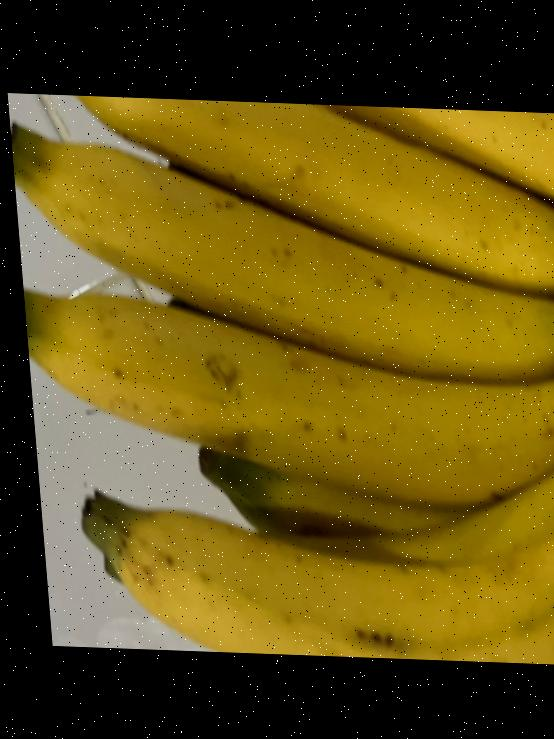

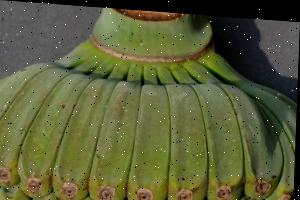

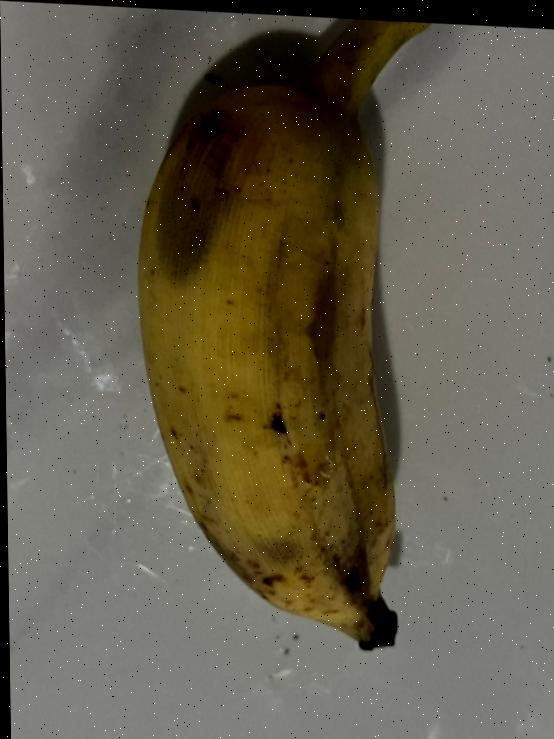

In [4]:
import requests
from PIL import Image

cavendish_banana_1_img = Image.open('./FDTwin/images/Cavendish-banana--1-_jpg.rf.2e9bf7467f538a9637bae28c4e0b2a70.jpg').convert('RGB')
display(cavendish_banana_1_img)
thep_phanom_7_img = Image.open('./FDTwin/images/thepphanom--7-_jpg.rf.3cd347d770e03c8839ab7d6cf565292a.jpg').convert('RGB')
display(thep_phanom_7_img)
cultivated_banana_2_img = Image.open('./FDTwin/images/cultivated-banana--2-_jpg.rf.e0646ebe05d265eeaf65eafb474bc1d2.jpg').convert('RGB')
display(cultivated_banana_2_img)

In [5]:
import torch
# This block will ensures the code runs on the GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# We need to set up a preprocessor to process the input to satisfy BLIP-2's
# required parameters. We also need to import the model itself
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
model.to(device)

2023-07-17 02:41:48.448984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 02:41:49.604387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-07-17 02:41:49.604509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [ ]:
# Asking BLIP-2 questions about each banana
def ask_a_question(question, banana_file):
    inputs = processor(banana_file, text=question, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print(question, generated_text)

def asking_questions(banana_file):
    ask_a_question("Question: Describe the input image. Answer:", banana_file)
    ask_a_question("Question: Is the banana in the image green? Answer:", banana_file)
    ask_a_question("Question: Is the banana in the image yellow? Answer:", banana_file)
    # ask_a_question("Question: Is the banana brown? Answer:", banana_file)
    # ask_a_question("Question: Is the banana black? Answer:", banana_file)
    ask_a_question("Question: Are there brown spots on the banana in the image? Answer:", banana_file)
    ask_a_question("Question: Describe the input image. Answer:", banana_file)
    ask_a_question("Question: Looking at just the outer skin of the banana, does the banana in the input image have brown patches? Answer:", banana_file)
    ask_a_question("Question: Do the bananas look healthy? Answer:", banana_file)
    ask_a_question("Question: Is this banana going to be tasty to eat? Answer:", banana_file)
    ask_a_question("Question: Is there any mold on this banana? Answer:", banana_file)
    ask_a_question("Question: How do you know if a banana has been sprayed with pesticides? Answer:", banana_file)
    ask_a_question("Question: Is this banana in the input image ripe? Answer:", banana_file)

print("Thep phanom 7:")
asking_questions(thep_phanom_7_img)

print("\nCavendish banana 1:")
asking_questions(cavendish_banana_1_img)

print("\nCultivated banana 2:")
asking_questions(cultivated_banana_2_img)

In [ ]:
# Running the model on Cavendish-banana--1-_jpg WITH context
context = [
   ("When will a green banana be ripe?", "7 days"),
   ("When will a yellow banana with no spots be ripe?", "5 days"),
   ("When will a yellow banana with some brown spots be ripe?", "3 days"),
   ("When will a yellow banana with a brown patches be ripe?", "1 day"),
   ("When will a yellow banana with a couple brown patches be ripe?", "it is already ripe"),
   ("When will a brown banana be ripe?", "it is overripe"),
   ("When will a black banana be ripe?", "it is very overripe")
]
question = "How many days will it take for this banana to be fully ripe?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

inputs = processor(cavendish_banana_1_img, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("output:", generated_text)

In [ ]:
# Running the model on Cavendish-banana--1-_jpg WITHOUT context
context = []
question = "How many days will it take for this banana to be fully ripe?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

inputs = processor(cavendish_banana_1_img, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("output:", generated_text)

In [ ]:
# Running the model on Cavendish-banana--1-_jpg WITH MINIMAL context
context = [
    ("","")
]
question = "What food item is this? How many days will it take for this food item to be fully ripe?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

inputs = processor(cavendish_banana_1_img, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("output:", generated_text)

In [ ]:
# Running the model on Thep-phanom-7-_jpg WITH context
# context = []
context = [
   ("When will a green banana be ripe?", "7 days"),
   ("When will a yellow banana with no spots be ripe?", "5 days"),
   ("When will a yellow banana with some brown spots be ripe?", "3 days"),
   ("When will a yellow banana with a brown patches be ripe?", "1 day"),
   ("When will a yellow banana with a couple brown patches be ripe?", "it is already ripe"),
   ("When will a brown banana be ripe?", "it is overripe"),
   ("When will a black banana be ripe?", "it is very overripe")
]
question = "How many days will it take for this banana to be fully ripe?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

inputs = processor(thep_phanom_7_img, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("output:", generated_text)

In [ ]:
# Running the model on Thep-phanom-7-_jpg WITHOUT context
# context = []
context = []
question = "How many days will it take for this banana to be fully ripe?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

inputs = processor(thep_phanom_7_img, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("output:", generated_text)

In [ ]:
# Running the model on cultivated_banana_2.img WITH context
context = [
   ("When will a green banana be ripe?", "7 days"),
   ("When will a yellow banana with no spots be ripe?", "5 days"),
   ("When will a yellow banana with some brown spots be ripe?", "3 days"),
   ("When will a yellow banana with a brown patches be ripe?", "1 day"),
   ("When will a yellow banana with a couple brown patches be ripe?", "it is already ripe"),
   ("When will a brown banana be ripe?", "it is overripe"),
   ("When will a black banana be ripe?", "it is very overripe")
]
# question = "How many days will it take for this banana to be fully ripe?"
question = "How many days will it take for this banana to be fully ripe"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

inputs = processor(cultivated_banana_2_img, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("output:", generated_text)

In [ ]:
# Running the model on cultivated_banana_2.img WITHOUT context
context = []
# question = "How many days will it take for this banana to be fully ripe?"
question = "How many days will it take for this banana to be fully ripe"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

inputs = processor(cultivated_banana_2_img, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("output:", generated_text)